In [2]:
!pip install xgboost matplotlib
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [48]:
import pandas as pd
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [49]:
power_data = pd.read_csv('artifacts/power_cleaned_data.csv')
power_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,53,20:00,7.96,3.38,34.93,45.50,212.74,1.00,1.00,1.00,-0.23,886.17
1,1,53,20:10,8.97,-1.94,34.90,45.54,207.82,1.00,1.00,1.00,-0.21,1071.01
2,1,53,20:20,8.98,5.65,34.85,45.58,220.33,1.00,1.00,1.00,-0.20,1143.00
3,1,53,20:30,8.12,1.19,34.52,45.49,251.20,1.00,1.00,1.00,-0.20,931.46
4,1,53,20:40,5.89,-1.71,34.24,45.46,249.54,0.99,0.99,0.99,-0.24,441.20


In [50]:
class DataCleaner:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Apply all abnormal conditions to filter out invalid data
        conditions = [
            self.data['Patv'] < 0,
            (self.data['Wspd'] < 1) & (self.data['Patv'] > 10),
            (self.data['Wspd'] < 2) & (self.data['Patv'] > 100),
            (self.data['Wspd'] < 3) & (self.data['Patv'] > 200),
            (self.data['Wspd'] > 2.5) & (self.data['Patv'] == 0),
            (self.data['Wspd'] == 0) & (self.data['Wdir'] == 0) & (self.data['Etmp'] == 0),
            self.data['Etmp'] < -21,
            self.data['Itmp'] < -21,
            self.data['Etmp'] > 60,
            self.data['Itmp'] > 70,
            (self.data['Wdir'] > 180) | (self.data['Wdir'] < -180),
            (self.data['Ndir'] > 720) | (self.data['Ndir'] < -720),
            (self.data['Pab1'] > 89) | (self.data['Pab2'] > 89) | (self.data['Pab3'] > 89)
        ]
        
        # Combine all conditions with OR operator
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition |= condition
        
        # Filter out rows that meet any of the abnormal conditions
        self.data = self.data[~combined_condition]

        self.data = self.data.dropna()
        return self.data

# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(power_data)
cleaned_data = cleaner.clean_data()


# Display the first few rows of the cleaned dataframe to verify the data is cleaned correctly
cleaned_data.head()

train, test = train_test_split(cleaned_data, test_size=0.5, random_state=42)
train

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
2588,1,78,01:30,3.19,1.74,31.47,40.79,-29.63,0.99,0.99,0.99,-0.25,129.64
269,1,56,04:10,9.58,-4.62,30.39,43.09,8.20,1.00,1.00,1.00,-0.24,1237.39
629,1,58,18:30,7.12,0.09,28.94,39.14,244.08,1.00,1.00,1.00,-0.24,762.42
1730,1,70,22:20,5.99,2.29,35.31,43.90,303.76,1.00,1.00,1.00,-0.24,439.01
1033,1,63,10:50,5.75,0.67,33.88,43.66,75.57,0.99,0.99,0.99,-0.26,437.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1,64,07:30,7.42,2.84,31.09,38.78,39.67,1.00,1.00,1.00,-0.27,668.30
1294,1,65,14:50,5.66,3.42,39.05,48.34,19.73,1.09,1.09,1.08,-0.02,314.80
860,1,60,15:30,8.62,3.29,38.04,49.27,416.92,1.00,1.00,1.00,-0.31,1061.76
3507,1,86,14:40,6.71,1.91,34.70,44.53,223.51,1.00,1.00,1.00,-0.21,688.53


In [51]:
# encode Tmstamp column to numeric values
train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9

/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_88199/3317315984.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_88199/3317315984.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9


<Axes: >

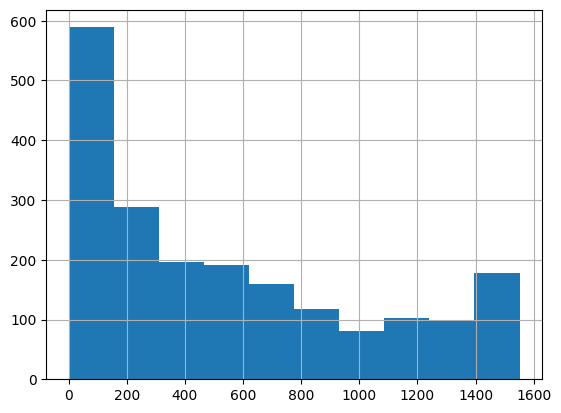

In [52]:
train["Patv"].hist()

<Axes: >

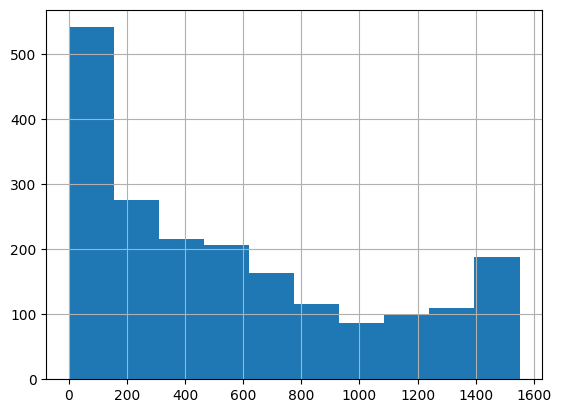

In [53]:
test["Patv"].hist()

In [54]:
# Split the data into training and testing sets
X = train.drop(columns=['Patv'])
y = train['Patv']

X_test = test.drop(columns=['Patv'])
y_test = test['Patv']

# Train an XGBoost model 
original_model = XGBRegressor()
original_model.fit(X, y)

# Make predictions on the test set
y_pred = original_model.predict(X_test)

# Calculate the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1251.4529064359335
Mean Absolute Error: 20.408584720100553


### GAN synthesized data

In [55]:
from synthetic_energy.time_series import DGAN, DGANConfig
# disable mps device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


features = train.to_numpy()
n_time_points = 2
n = features.shape[0] // n_time_points
features = features[: n * n_time_points, :].reshape(
    -1, n_time_points, features.shape[1]
)

config = DGANConfig(max_sequence_len=20, sample_len=5, batch_size=10, epochs=10, cuda=False)
dg = DGAN(config=config)

dg.train_numpy(
    features=features,
)

attributes, features = dg.generate_numpy(n=100)

print(features[0])

2024-12-04 01:20:12 [info     ] Training DGAN model            dtype=dtype('float64') features_length=1000 first_sequence_shape=(2, 13)
2024-12-04 01:20:12 [info     ] Determining outputs metadata from input data
2024-12-04 01:20:12 [info     ] Building DGAN networks        
2024-12-04 01:20:12 [info     ] Checking for nans in the numeric columns number_of_columns=13
2024-12-04 01:20:12 [info     ] Applying linear interpolations for nans (does not mean nans are present)
2024-12-04 01:20:12 [info     ] Creating encoded array of features
2024-12-04 01:20:12 [info     ] Creating encoded array of attributes
2024-12-04 01:20:12 [info     ] Training...                    dtype=dtype('float32') internal_additional_attributes_shape=(1000, 26) internal_attributes_shape=(1000, 1) internal_features_shape=(1000, 20, 13)
2024-12-04 01:20:12 [info     ] Creating TensorDataset        
2024-12-04 01:20:12 [info     ] Calling _train()              
2024-12-04 01:20:12 [info     ] Training              

/Users/ruimelo/anaconda3/envs/phd/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


2024-12-04 01:20:14 [info     ] Training                       epoch=1
2024-12-04 01:20:15 [info     ] Training                       epoch=2
2024-12-04 01:20:17 [info     ] Training                       epoch=3
2024-12-04 01:20:19 [info     ] Training                       epoch=4
2024-12-04 01:20:20 [info     ] Training                       epoch=5
2024-12-04 01:20:22 [info     ] Training                       epoch=6
2024-12-04 01:20:24 [info     ] Training                       epoch=7
2024-12-04 01:20:25 [info     ] Training                       epoch=8
2024-12-04 01:20:27 [info     ] Training                       epoch=9
[[ 1.00000000e+00  7.64138865e+01  1.73334559e+09  2.27433814e+00
  -2.45182246e+00  3.53815937e+01  4.10253223e+01  1.80796365e+02
   1.07995531e+00  1.03613332e+00  1.01819567e+00 -2.00128386e-01
   5.42324308e+01]
 [ 1.00000000e+00  5.76693326e+01  1.73330589e+09  4.00922981e+00
  -4.86169376e+00  3.60673018e+01  4.15876131e+01  6.35496090e+01
   1.1747772

In [56]:
import numpy as np
import pandas as pd

# Define the column names
columns = ["TurbID", "Day", "Tmstamp", "Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]

# Convert the generated list to a NumPy array
features_array = np.array(features)

# Reshape the array and convert it to a DataFrame
synthetic_df = pd.DataFrame(features_array.reshape(-1, features_array.shape[-1]), columns=columns)

synthetic_df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,76.413887,1.733346e+09,2.274338,-2.451822,35.381594,41.025322,180.796365,1.079955,1.036133,1.018196,-0.200128,54.232431
1,1.0,57.669333,1.733306e+09,4.009230,-4.861694,36.067302,41.587613,63.549609,1.174777,1.167686,1.143579,-0.171778,706.108050
2,1.0,57.405705,1.733306e+09,2.354025,-4.829157,33.043915,40.187242,48.742153,1.060601,1.039452,0.997281,-0.209346,73.226957
3,1.0,57.600519,1.733307e+09,2.317291,-4.861958,33.106951,40.190155,48.162359,1.064469,1.025948,0.996440,-0.209693,61.461714
4,1.0,57.776805,1.733306e+09,2.334353,-4.837410,33.059214,40.189178,48.754724,1.058058,1.031123,0.994553,-0.209241,64.509875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,59.839021,1.733310e+09,1.812023,0.814169,32.374366,40.718063,16.178592,1.001571,1.001281,0.974553,-0.230584,63.758165
1996,1.0,59.847978,1.733310e+09,1.805052,0.814645,32.400505,40.733359,14.293287,1.001522,1.001229,0.974468,-0.230693,61.937861
1997,1.0,59.833427,1.733310e+09,1.798195,0.813146,32.365468,40.713287,14.271168,1.001513,1.001241,0.974468,-0.230721,61.154774
1998,1.0,59.833671,1.733310e+09,1.797666,0.813128,32.365880,40.713251,14.268871,1.001520,1.001228,0.974469,-0.230721,60.884910


<Axes: >

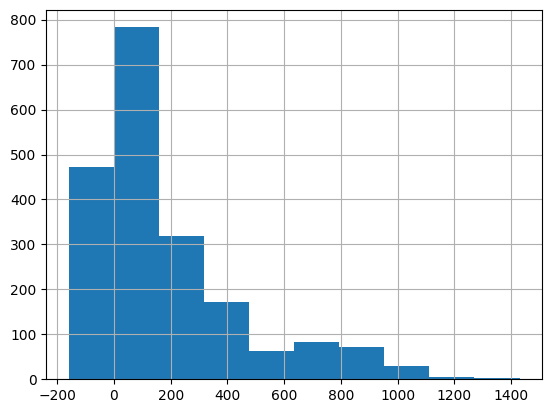

In [57]:
synthetic_df["Patv"].hist()

<Axes: >

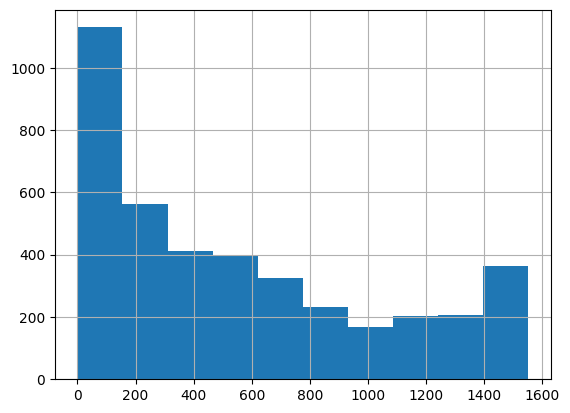

In [58]:
cleaned_data["Patv"].hist()

In [ ]:
# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(synthetic_df)
synthesized_cleaned_data = cleaner.clean_data()
# Assuming synthesized_cleaned_data is your DataFrame
synthesized_cleaned_data = synthesized_cleaned_data.astype(float)
synthesized_cleaned_data['Tmstamp'] = pd.to_datetime(synthesized_cleaned_data['Tmstamp']).astype(int) // 10**9

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,76.413887,1.733346e+09,2.274338,-2.451822,35.381594,41.025322,180.796365,1.079955,1.036133,1.018196,-0.200128,54.232431
1,1.0,57.669333,1.733306e+09,4.009230,-4.861694,36.067302,41.587613,63.549609,1.174777,1.167686,1.143579,-0.171778,706.108050
2,1.0,57.405705,1.733306e+09,2.354025,-4.829157,33.043915,40.187242,48.742153,1.060601,1.039452,0.997281,-0.209346,73.226957
3,1.0,57.600519,1.733307e+09,2.317291,-4.861958,33.106951,40.190155,48.162359,1.064469,1.025948,0.996440,-0.209693,61.461714
4,1.0,57.776805,1.733306e+09,2.334353,-4.837410,33.059214,40.189178,48.754724,1.058058,1.031123,0.994553,-0.209241,64.509875


In [87]:
# Split the data into training and testing sets
X_synth_train, X_synth_test = train_test_split(synthesized_cleaned_data, test_size=0.5, random_state=42)

y_synth_train = X_synth_train['Patv']
X_synth_train = X_synth_train.drop(columns=['Patv'])

y_synth_test = X_synth_test['Patv']
X_synth_test = X_synth_test.drop(columns=['Patv'])


# Train an XGBoost model 
synthetic_model = XGBRegressor()
synthetic_model.fit(X_synth_train, y_synth_train)

# Make predictions on the test set
y_pred_synth = synthetic_model.predict(X_synth_test)

# Calculate the mean squared error and mean absolute error
mse = mean_squared_error(y_synth_test, y_pred_synth)
mae = mean_absolute_error(y_synth_test, y_pred_synth)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3327.3382880489644
Mean Absolute Error: 18.47808933493474


In [88]:
synthetic_df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,76.413887,1.733346e+09,2.274338,-2.451822,35.381594,41.025322,180.796365,1.079955,1.036133,1.018196,-0.200128,54.232431
1,1.0,57.669333,1.733306e+09,4.009230,-4.861694,36.067302,41.587613,63.549609,1.174777,1.167686,1.143579,-0.171778,706.108050
2,1.0,57.405705,1.733306e+09,2.354025,-4.829157,33.043915,40.187242,48.742153,1.060601,1.039452,0.997281,-0.209346,73.226957
3,1.0,57.600519,1.733307e+09,2.317291,-4.861958,33.106951,40.190155,48.162359,1.064469,1.025948,0.996440,-0.209693,61.461714
4,1.0,57.776805,1.733306e+09,2.334353,-4.837410,33.059214,40.189178,48.754724,1.058058,1.031123,0.994553,-0.209241,64.509875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,59.839021,1.733310e+09,1.812023,0.814169,32.374366,40.718063,16.178592,1.001571,1.001281,0.974553,-0.230584,63.758165
1996,1.0,59.847978,1.733310e+09,1.805052,0.814645,32.400505,40.733359,14.293287,1.001522,1.001229,0.974468,-0.230693,61.937861
1997,1.0,59.833427,1.733310e+09,1.798195,0.813146,32.365468,40.713287,14.271168,1.001513,1.001241,0.974468,-0.230721,61.154774
1998,1.0,59.833671,1.733310e+09,1.797666,0.813128,32.365880,40.713251,14.268871,1.001520,1.001228,0.974469,-0.230721,60.884910


In [94]:
from synthetic_energy.quality_metrics import (
    WassersteinDistance,
    KLDivergence,
    PopulationStabilityIndex
)




# Calculate the Wasserstein distance between the original and synthetic data
wd = WassersteinDistance()
wd_value = wd(train, synthetic_df)
print(f'Wasserstein Distance: {wd_value}')

# Calculate the Kullback-Leibler divergence between the original and synthetic data
kl = KLDivergence()
kl_value = kl(train, synthetic_df)
print(f'KL Divergence: {kl_value}')

# Calculate the Population Stability Index between the original and synthetic data
psi = PopulationStabilityIndex()
psi_value = psi(train, synthetic_df)
print(f'Population Stability Index: {psi_value}')


Wasserstein Distance: 0.6544444444444445
KL Divergence: 11.162492335023256
Population Stability Index: 18.156848063022842


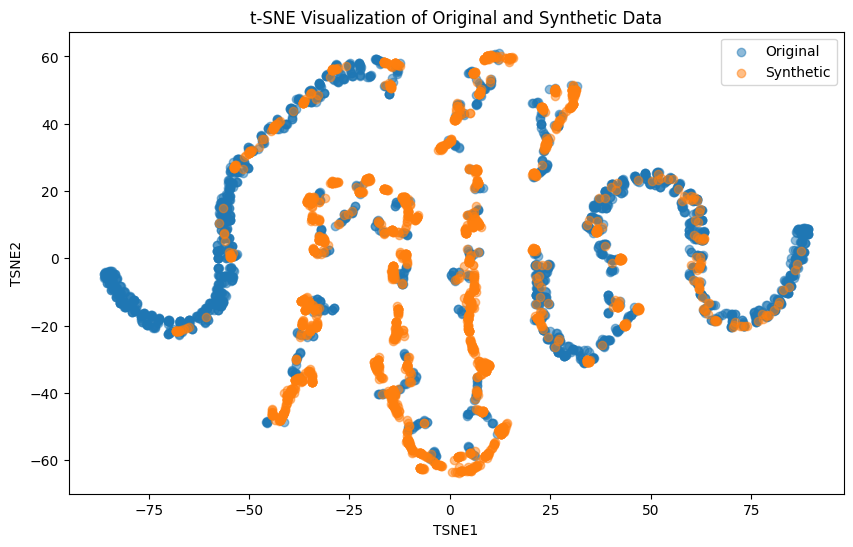

In [67]:
from sklearn.manifold import TSNE

# Combine the original and synthetic data for t-SNE visualization
combined_data = np.vstack((train.values, synthetic_df.values))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = ['Original'] * len(train) + ['Synthetic'] * len(synthetic_df)

# Plot the results
plt.figure(figsize=(10, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=label, alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Original and Synthetic Data')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

## Membership Inference Attack

In [79]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# train dataframe was used to train the classifier and test wasnt used. 
# Now the attack model is trained with samples from both train and test labeled as 1 and 0 respectively (0 being the training data)

# Label the data
train['label'] = 1
test['label'] = 0


# Combine the data
attack_data = pd.concat([train, test])

# shuffle the data
attack_data = attack_data.sample(frac=1, random_state=42)

# Split the data into features and labels
X_attack = attack_data.drop(columns=['label'])
y_attack = attack_data['label']

attack_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,label
3180,1,83,1733286600,0.88,43.96,31.24,41.60,273.34,1.90,1.90,1.90,-0.30,0.00,1
1459,1,68,1733339400,4.74,3.68,40.12,47.18,172.95,0.99,0.99,0.99,-0.24,262.77,0
1700,1,70,1733329800,4.71,1.97,37.75,44.99,220.96,0.99,0.99,0.99,-0.25,253.91,1
426,1,57,1733301600,10.30,-0.32,31.17,43.79,30.98,1.01,1.01,1.01,-0.24,1429.19,0
2086,1,73,1733356200,7.97,0.61,31.09,43.30,80.64,1.00,1.00,1.00,-0.28,822.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,1,65,1733281200,7.12,0.26,30.40,41.49,8.81,1.00,1.00,1.00,-0.26,642.09,1
3447,1,86,1733271000,5.07,0.11,30.05,41.37,264.69,0.99,0.99,0.99,-0.24,340.86,1
1755,1,71,1733279400,9.15,2.55,30.76,41.59,384.71,1.00,1.00,1.00,-0.29,1096.68,1
930,1,62,1733332800,2.31,-91.51,37.59,40.70,221.67,1.83,1.83,1.83,0.00,0.00,0


In [80]:
original_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [81]:
# Pass through regressor model to get the predictions
attack_data['Patv'] = original_model.predict(X_attack.drop(columns=['Patv']))
attack_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,label
3180,1,83,1733286600,0.88,43.96,31.24,41.60,273.34,1.90,1.90,1.90,-0.30,-0.398874,1
1459,1,68,1733339400,4.74,3.68,40.12,47.18,172.95,0.99,0.99,0.99,-0.24,264.292328,0
1700,1,70,1733329800,4.71,1.97,37.75,44.99,220.96,0.99,0.99,0.99,-0.25,259.772461,1
426,1,57,1733301600,10.30,-0.32,31.17,43.79,30.98,1.01,1.01,1.01,-0.24,1419.949463,0
2086,1,73,1733356200,7.97,0.61,31.09,43.30,80.64,1.00,1.00,1.00,-0.28,849.339600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,1,65,1733281200,7.12,0.26,30.40,41.49,8.81,1.00,1.00,1.00,-0.26,648.550842,1
3447,1,86,1733271000,5.07,0.11,30.05,41.37,264.69,0.99,0.99,0.99,-0.24,340.945892,1
1755,1,71,1733279400,9.15,2.55,30.76,41.59,384.71,1.00,1.00,1.00,-0.29,1095.542480,1
930,1,62,1733332800,2.31,-91.51,37.59,40.70,221.67,1.83,1.83,1.83,0.00,5.337205,0


In [83]:
import torch
import torch.nn as nn


class AttackerModel(nn.Module):
    def __init__(self, input_dim):
        super(AttackerModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    

# Define the model
attacker_model = AttackerModel(input_dim=X_attack.shape[1])

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(attacker_model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X_attack.values, dtype=torch.float32).view(-1, X_attack.shape[1])
y_tensor = torch.tensor(y_attack.values, dtype=torch.float32).view(-1, 1)


In [84]:

# Train the model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = attacker_model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Get the predictions from the model
predictions = attacker_model(X_tensor).detach().numpy()
predictions = (predictions > 0.5).astype(int)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_attack, predictions)
print(f'Accuracy: {accuracy}')



Epoch 1, Loss: 50.0
Epoch 2, Loss: 50.0
Epoch 3, Loss: 50.0
Epoch 4, Loss: 50.0
Epoch 5, Loss: 50.0
Epoch 6, Loss: 50.0
Epoch 7, Loss: 50.0
Epoch 8, Loss: 50.0
Epoch 9, Loss: 50.0
Epoch 10, Loss: 50.0
Epoch 11, Loss: 50.0
Epoch 12, Loss: 50.0
Epoch 13, Loss: 50.0
Epoch 14, Loss: 50.0
Epoch 15, Loss: 50.0
Epoch 16, Loss: 50.0
Epoch 17, Loss: 50.0
Epoch 18, Loss: 50.0
Epoch 19, Loss: 50.0
Epoch 20, Loss: 50.0
Epoch 21, Loss: 50.0
Epoch 22, Loss: 50.0
Epoch 23, Loss: 50.0
Epoch 24, Loss: 50.0
Epoch 25, Loss: 50.0
Epoch 26, Loss: 50.0
Epoch 27, Loss: 50.0
Epoch 28, Loss: 50.0
Epoch 29, Loss: 50.0
Epoch 30, Loss: 50.0
Epoch 31, Loss: 50.0
Epoch 32, Loss: 50.0
Epoch 33, Loss: 50.0
Epoch 34, Loss: 50.0
Epoch 35, Loss: 50.0
Epoch 36, Loss: 50.0
Epoch 37, Loss: 50.0
Epoch 38, Loss: 50.0
Epoch 39, Loss: 50.0
Epoch 40, Loss: 50.0
Epoch 41, Loss: 50.0
Epoch 42, Loss: 50.0
Epoch 43, Loss: 50.0
Epoch 44, Loss: 50.0
Epoch 45, Loss: 50.0
Epoch 46, Loss: 50.0
Epoch 47, Loss: 50.0
Epoch 48, Loss: 50.0
E